In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import AgglomerativeClustering
from igraph import Graph, plot
import matplotlib.pyplot as plt
import skbio
import subprocess
import utils
import manta
from scipy.cluster.hierarchy import dendrogram
import itertools
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles
from collections import Counter
from venn import venn

%load_ext autoreload
%aimport utils
%aimport manta
%autoreload 1

# Read data and preprocess

In [2]:
TAX_LEVEL = 4
OUTDIR = 'data/18S_l5_ur'
SEASON = 'Upwelling Relaxation'

In [3]:
# Read data
df_raw = pd.read_excel('data/18S_AV_OTU_table_wTaxa.xlsx')
meta = pd.read_excel('data/18S_AV_March2019_Metadata.xlsx')
meta

,Sample_Names,Sample_NamesR,AV_Numbers,Month,Year,Season,Temp_C,Salinity,Chlorophyll_ugL
0,AV12-18S,AV12_Jan_2018,AV180126,January,2018,Winter Storms,12.60,33.4,NaN
1,AV13-18S,AV13_Feb_2018,AV180202,February,2018,Winter Storms,13.80,33.4,NaN
2,AV14-18S,AV14_Feb_2018,AV180209,February,2018,Winter Storms,14.30,33.4,18.916
3,AV17-2-18S,AV17_Feb_2018_2,AV180216,February,2018,Winter Storms,13.10,33.4,1.624
4,AV18-18S,AV18_Feb_2018,AV180223,February,2018,Winter Storms,12.00,33.4,1.818
5,AV19-18S,AV19_Mar_2018,AV180302,March,2018,March Transition,11.50,33.3,1.113
6,AV22-18S,AV22_Mar_2018,AV180309,March,2018,March Transition,12.72,33.4,7.338
7,AP-AV23-AV180316-18S,AV23_Mar_2018,AV180316,March,2018,March Transition,13.00,33.4,3.602
8,AV26-18S,AV26_Apr_2018,AV180413,April,2018,Peak Upwelling,10.60,33.7,0.652
9,AP-AV29-AV180420-18S,AV29_Apr_2018,AV180420,April,2018,Peak Upwelling,11.30,33.3,8.615


In [4]:
# Split taxonomy
df_raw['taxonomy'] = df_raw['taxonomy'].str.split('; ')
# Taxonomy depth distribution
tax_depth = df_raw['taxonomy'].apply(len)
tax_depth.value_counts()

8    8258
7    1058
6     265
4     228
5     160
3      10
2       2
1       2
Name: taxonomy, dtype: int64

In [5]:
# Filter out OTUs with coarser taxonomy than the desired level and group them at that level
df_raw = df_raw[tax_depth >= TAX_LEVEL]
df_raw['taxonomy'] = df_raw['taxonomy'].apply(lambda x: '; '.join(x[:TAX_LEVEL]))
df = df_raw.groupby('taxonomy').aggregate(np.sum)
df

,AV22-18S,AV17-2-18S,AV13-18S,AP-AV29-AV180420-18S,AV44-18S,AV53-18S,AV32-18S,AV12-18S,AV38-18S,AV90-18S,...,AV14-18S,AV59-18S,AV66-18S,AV50-18S,AV78-18S,AV81-18S,AV75-18S,AV72-18S,AV69-18S,AV56-18S
taxonomy,,,,,,,,,,,,,,,,,,,,,
Eukaryota; Alveolata; Apicomplexa; Apicomplexa_X,22,7,4,18,161,0,2,22,24,532,...,0,0,0,1,1,1,51,1,0,0
Eukaryota; Alveolata; Ciliophora; CONTH_3,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
Eukaryota; Alveolata; Ciliophora; CONTH_6,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
Eukaryota; Alveolata; Ciliophora; CONTH_8,1,1,0,0,9,0,157,0,0,0,...,0,1,0,3,0,1,0,0,0,0
Eukaryota; Alveolata; Ciliophora; CONThreeP,37,46,8,0,36,2,100,8,128,82,...,0,0,0,6,0,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Eukaryota; Stramenopiles; Stramenopiles_X; Pirsonia_Clade,1,0,1,0,0,0,0,4,1,141,...,0,0,0,0,0,0,0,0,0,0
Eukaryota; Stramenopiles; Stramenopiles_X; Stramenopiles_X-Group-2,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
Eukaryota; Stramenopiles; Stramenopiles_X; Stramenopiles_X-Group-6,0,0,0,0,0,0,0,2,0,223,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Effective number of species
np.exp(skbio.diversity.alpha_diversity('shannon', df.transpose())).mean()

4.759163478066598

# Filter vertices

In [7]:
samples = meta['Sample_Names'][meta['Season'] == SEASON]
df = df[samples]

In [8]:
df_relative = df / df.sum()
df = df[((df > 0).sum(axis=1) > 2) | (df_relative > .01).any(axis=1)]

In [12]:
df /= df.sum()

In [13]:
df.to_csv('18s_ur_1percent_3samples.csv')

In [11]:
df

,AV50-18S,AV53-18S,AV56-18S,AV59-18S,AV66-18S,AV69-18S
taxonomy,,,,,,
Eukaryota; Alveolata; Ciliophora; Nassophorea,1,4,0,0,2,0
Eukaryota; Alveolata; Ciliophora; Phyllopharyngea,3,5,0,3,1,0
Eukaryota; Alveolata; Ciliophora; Spirotrichea,48,85,0,58,3,1
Eukaryota; Alveolata; Dinoflagellata; Dinophyceae,13223,135786,18691,11176,12770,23810
Eukaryota; Alveolata; Dinoflagellata; Syndiniales,115,994,3,159,20,4
Eukaryota; Archaeplastida; Chlorophyta; Chloropicophyceae,3,44,0,1,1,1
Eukaryota; Archaeplastida; Chlorophyta; Mamiellophyceae,292,74,1,29,0,0
Eukaryota; Archaeplastida; Chlorophyta; Prasino-Clade-V,1,5,0,1,0,0
Eukaryota; Archaeplastida; Chlorophyta; Pyramimonadales,5,90,0,17,2,1


# Build graph

In [15]:
df_cor, df_pval = utils.run_sparcc(df, OUTDIR, force=True)

(array([ 6., 19., 24., 47., 49., 45., 27., 20.,  6., 10.]),
 array([-0.6836 , -0.53824, -0.39288, -0.24752, -0.10216,  0.0432 ,
         0.18856,  0.33392,  0.47928,  0.62464,  0.77   ]),
 <a list of 10 Patch objects>)

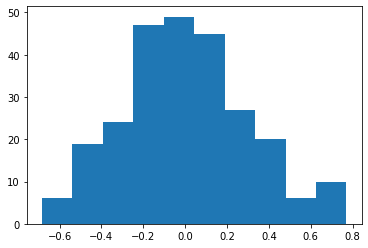

In [16]:
flatten_cor = utils.flatten_square_df(df_cor, k=1)
plt.hist(flatten_cor)

In [17]:
g = utils.build_graph(df_cor, df_pval)
utils.graph_stats(g)

# edges: 0


KeyError: 'Attribute does not exist'

In [10]:
len(g.vs)

34

# Run manta

In [11]:
g = g.components().subgraph(0)
g.write_gml(os.path.join(OUTDIR, 'graph.gml'))

In [4]:
subprocess.run(['manta',
                '-i', os.path.join(OUTDIR, 'graph.gml'),
                '-o', os.path.join(OUTDIR, 'graph_manta'),
                '-min', '2',
                '-max', '4',
                '-f', 'gml',
                '-b',
                '-v',
               ],
               check=True)
g_manta = Graph.Read_GML(os.path.join(OUTDIR, 'graph_manta.gml'))

In [16]:
utils.graph_stats(g_manta)

# edges: 108
# positive edges: 58
# negative edges: 50
max degree: 21
min degree: 1
median degree: 6.0
transitivity: 0.4211099020674646


In [22]:
#g_manta.vs.select(assignment='weak').delete()

In [18]:
Counter(g_manta.vs['cluster'])

Counter({1.0: 18, 0.0: 14})

In [96]:
#g_manta.vs.select(cluster=0.0)['label']

In [33]:
# sets = {
#     'pu_0': set(g_pu_manta.vs.select(cluster=0.0)['label']),
#     'pu_1': set(g_pu_manta.vs.select(cluster=1.0)['label']),
#     'ur_0': set(g_ur_manta.vs.select(cluster=0.0)['label']),
#     'ur_1': set(g_ur_manta.vs.select(cluster=1.0)['label'])
# }
# fig, ax = plt.subplots(1, figsize=(16,12))
# venn(sets, ax=ax)
# #plt.legend(labels[:-2], ncol=6)

In [19]:
g_manta.es['abs_weight'] = list(map(abs, g_manta.es['weight']))

In [20]:
def assign_color(e):
    if e.source_vertex['cluster'] == e.target_vertex['cluster']:
        return 'green' if e['weight'] >= 0 else 'red'
    else:
        return 'blue' if e['weight'] >= 0 else 'orange'
g_manta.es['color'] = list(map(assign_color, g_manta.es))

In [21]:
def clean_label(label):
    return '; '.join(map(lambda x: x.strip('_'), label.split('; ')[1:]))
g_manta.vs['label'] = list(map(clean_label, g_manta.vs['label']))

In [22]:
g_manta.write_gml(os.path.join(OUTDIR, 'graph_cytoscape.gml'))

In [ ]:
g_pu.es.find(_between=((80,), (7,)))['weight']

In [ ]:
for clique in g_pu.cliques(3):
    all_negative = True
    for v1,v2 in itertools.combinations(clique, 2):
        if g_pu.es.find(_between=((v1,), (v2,)))['weight'] > 0:
            all_negative = False
    if all_negative:
        print(clique)

In [ ]:
g_pu.es.select(weight_lt=0).delete()
g_ur.es.select(weight_lt=0).delete()
g_pu.vs.select(_degree=0).delete()
g_ur.vs.select(_degree=0).delete()

In [ ]:
g_ur.clique_number()

In [ ]:
# p, labels = plot_graph(g_pu)
# p

In [ ]:
# g_pu.vs['label'] = labels

In [ ]:
# p, labels = plot_graph(g_ur)
# p

In [ ]:
# g_ur.vs['label'] = labels

In [ ]:
# hierarchical clustering
adjacency_matrix = np.array(g_pu.get_adjacency(attribute='weight').data)
adjacency_matrix[adjacency_matrix < 0] = 0
# adjacency_matrix = (adjacency_matrix + 1) / 2
adjacency_matrix = 1 - adjacency_matrix
clusteror = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='complete', distance_threshold=.5)
a = clusteror.fit_predict(adjacency_matrix)

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clusteror, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
# for e in g_pu.es.select(weight_ge=.7):
#     print(e.source_vertex['label'], e.target_vertex['label'], e['weight'])

In [ ]:
# plot(g_pu.degree_distribution())

In [ ]:
# for v in g_pu.vs.select(_degree_ge=40):
#     print(v['label'])

In [ ]:
# ccs = g_pu.components()
# ccs = [ccs.subgraph(i) for i, vs in enumerate(ccs) if len(vs) > 1]
# print(f'Number of components: {len(ccs)}')

In [ ]:
# for cc in ccs:
#     print(len(cc.vs))

In [ ]:
clustering = g_pu.community_fastgreedy().as_clustering()
#small = [clustering.subgraph(i) for i, vs in enumerate(clustering) if len(vs) < 10][0]
#ccs[0].vs['label'] = None
#plot(clustering)

In [ ]:
for i in range(len(clustering)):
    module = clustering.subgraph(i)
    for v in module.vs:
        print(v['label'])
    print()

In [ ]:
clustering = g_ur.community_fastgreedy().as_clustering()
for i in range(len(clustering)):
    module = clustering.subgraph(i)
    for v in module.vs:
        print(v['label'])
    print()